# Advanced ML - EX1

## Load the data

### Imports

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load MNIST dataset
mnist = fetch_openml('mnist_784')


In [3]:
# Split the data into training and testing sets
# x_train, x_test = mnist.data[:60000], mnist.data[60000:]
# y_train, y_test = mnist.target[:60000], mnist.target[60000:]

x_train, x_test = mnist.data[:600], mnist.data[600:]
y_train, y_test = mnist.target[:600], mnist.target[600:]

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Print dataset shapes
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)


Training data shape: (600, 784)
Training labels shape: (600,)
Test data shape: (69400, 784)
Test labels shape: (69400,)



### Data exploration

Describe the data

In [4]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Columns: 784 entries, pixel1 to pixel784
dtypes: float64(784)
memory usage: 3.6 MB


In [5]:
null_vals = x_train.isna().sum()
print(f"There are {len(null_vals[null_vals != 0])} missing values in x_train.")

There are 0 missing values in x_train.


Present the label distribution

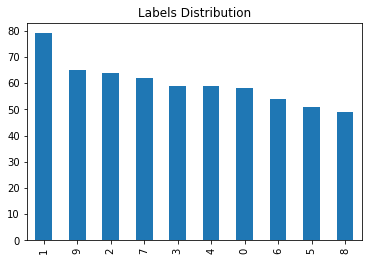

In [6]:
y_train.value_counts(dropna=False).plot(kind='bar')
plt.title("Labels Distribution") 
plt.show()

Present some of the images:

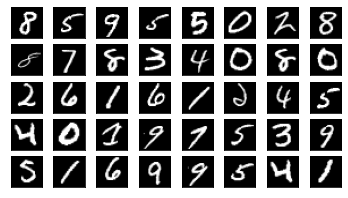

In [7]:
N=40
images= np.random.randint(low=0, high=600, size=N).tolist()

images = x_train.iloc[images,:]
# images.drop(columns=['label'], inplace=True)
images.index = range(1, N+1)

for i, row in images.iterrows():
    plt.subplot(N//8 + 1, 8, i)
    pixels = row.values.reshape((28,28))
    plt.imshow(pixels, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()


## Part 1 - Clustering

### Imports

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, completeness_score, homogeneity_score
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, f1_score


In [13]:
class AgglomerativeClusteringPredict(AgglomerativeClustering):
    def predict(self, x_test, x_train):
        # Get the cluster assignments of the training data
        labels = self.labels_
        # Get the unique cluster labels
        unique_labels = np.unique(labels)
        # Get the centroids of the clusters
        centroids = np.array([np.mean(x_train[labels == k], axis=0) for k in unique_labels])
        # Calculate the distance between each new data point and the centroids
        dist = np.array([np.linalg.norm(x_test - c, axis=1) for c in centroids])
        # Assign each new data point to the closest centroid's cluster
        return unique_labels[np.argmin(dist, axis=0)]


### Cluster

In [9]:
def cluster_data(data, clustering_algorithm, hyperparams):
    """
    Cluster the input data using the specified clustering algorithm and hyperparameters.
    Parameters:
    data (numpy array): input data to be clustered
    clustering_algorithm (sklearn.cluster object): clustering algorithm object from scikit-learn
    hyperparams (dictionary): dictionary of hyperparameters for the clustering algorithm
    Returns:
    numpy array: cluster labels for each data point
    """    
    clustering_model = clustering_algorithm(**hyperparams)
    cluster_per_data_point = clustering_model.fit_predict(data)
    return clustering_model, cluster_per_data_point

### Visualize

In [10]:
def visualize_clusters(data, labels, n_clusters):
    """
    Visualize the clusters by displaying a few images from each cluster.
    Parameters:
    data (numpy array): input data to be clustered
    labels (numpy array): cluster labels for each data point
    n_clusters (int): number of clusters
    Returns:
    None
    """
    fig, ax = plt.subplots(n_clusters, 5, figsize=(8, 8))
    plt.title("CLusters and example images")
    for i in range(n_clusters):
        indices = np.where(labels == i)[0]
        for j in range(5):
            ax[i, j].imshow(data[indices[j]].reshape(28, 28), cmap='gray')
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
        ax[i, 0].set_ylabel(f'Cluster {i}', rotation=0, labelpad=20)
    plt.tight_layout()
    plt.show()


### Evaluation metrics

In [11]:
def evaluate_clustering(cluster_per_data_point, true_labels, data):
    """
    Evaluate the clustering result using three metrics: Silhouette score, completeness score,
    and homogeneity score.
    Parameters:
    cluster_per_data_point (numpy array): cluster labels for each data point
    true_labels (numpy array): true labels for each data point
    data (numpy array): input data to be clustered
    Returns:
    tuple: four clustering metrics: Silhouette score, completeness score, and homogeneity score.
    """
    silhouette_avg = silhouette_score(data, cluster_per_data_point)
    completeness_avg = completeness_score(true_labels, cluster_per_data_point)
    homogeneity_avg = homogeneity_score(true_labels, cluster_per_data_point)
    return silhouette_avg, completeness_avg, homogeneity_avg

In [12]:
def build_classifier_and_evaluate(data, cluster_per_data_point, true_labels, clustering_model, clustering_algorithm, x_test, y_test):
    """
    Builds a classifier based on majority vote within the cluster given the data and the data_clusters.
    Also evaluates the classifier using accuracy and F1 metrics.
    return: accuracy & F1
    
    Parameters:
    data (numpy array): input data of shape (N, num_pixels)
    cluster_per_data_point (numpy array): (N, 1)
    true_labels (array): the classes for each data point
    clustering_model: sklearn class such as kmeans
    Returns:
    tuple: accuracy, f1
    """
    # Assign a label to each cluster based on majority vote
    unique_clusters = np.unique(cluster_per_data_point)
    cluster_labels = np.zeros(len(unique_clusters), dtype=int)
    for i, cluster in enumerate(unique_clusters):
        mask = (cluster_per_data_point == cluster)
        digit_counts = np.bincount(true_labels[mask])
        cluster_labels[i] = np.argmax(digit_counts)
    
    for i, cluster_label in enumerate(cluster_labels):
        print(f"For cluster: {i} the most common label is: {cluster_label}")
        
    # Predict the digit label of each test image based on its nearest cluster
    if  clustering_algorithm == AgglomerativeClusteringPredict:
        cluster_labels_test = clustering_model.predict(x_test, x_train)
    else:
        cluster_labels_test = clustering_model.predict(x_test)
    y_pred = np.array([cluster_labels[cluster] for cluster in cluster_labels_test])
    y_test = y_test.astype(int)
    # Evaluate the classifier using accuracy and F1 metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return accuracy, f1    


In [14]:

def run_pipeline(data, true_labels, clustering_algorithm, hyperparams, x_test, y_test):
    """
    Run the clustering pipeline on the input data using the specified clustering algorithm and hyperparameters,
    and return four clustering metrics: adjusted Rand score, Silhouette score, completeness score, and homogeneity score.
    Parameters:
    data (numpy array): input data to be clustered
    clustering_algorithm (sklearn.cluster object): clustering algorithm object from scikit-learn
    hyperparams (dictionary): dictionary of hyperparameters for the clustering algorithm

    Returns:
    tuple: four clustering metrics: adjusted Rand score, Silhouette score, completeness score, and homogeneity score.
    """
    # Cluster the data
    clustering_model, cluster_per_data_point = cluster_data(data, clustering_algorithm, hyperparams)
    # Evaluate the clustering
    silhouette_avg, completeness_avg, homogeneity_avg = evaluate_clustering(cluster_per_data_point, true_labels, data)
    num_clusters = hyperparams['n_clusters'] if clustering_algorithm != GaussianMixture else hyperparams['n_components']
    visualize_clusters(data, cluster_per_data_point, num_clusters)
    acc, f1 = build_classifier_and_evaluate(data, cluster_per_data_point, true_labels, clustering_model, clustering_algorithm, np.array(x_test), y_test)
    return silhouette_avg, completeness_avg, homogeneity_avg, acc, f1


### K Means

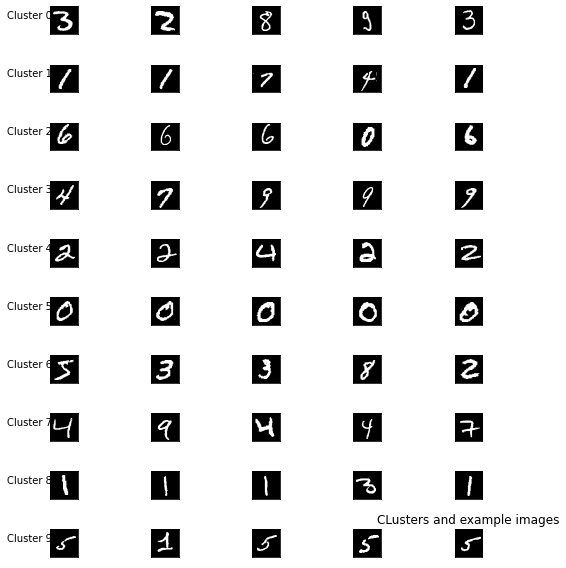

For cluster: 0 the most common label is: 3
For cluster: 1 the most common label is: 1
For cluster: 2 the most common label is: 6
For cluster: 3 the most common label is: 7
For cluster: 4 the most common label is: 2
For cluster: 5 the most common label is: 0
For cluster: 6 the most common label is: 8
For cluster: 7 the most common label is: 4
For cluster: 8 the most common label is: 1
For cluster: 9 the most common label is: 5


In [15]:

# init dict with clustering metrics
metrics_dict = {}

# KMEANS
n_clusters = len(set(y_train))
hyper_params = {'n_clusters': n_clusters}
silhouette_avg, completeness_avg, homogeneity_avg, acc, f1 = run_pipeline(np.array(x_train), y_train, KMeans, hyper_params, x_test, y_test)  
metrics_dict["kmeans"] = dict(zip(["silhouette_avg", "completeness_avg", "homogeneity_avg", "acc", "f1"], [silhouette_avg, completeness_avg, homogeneity_avg, acc, f1]))



### K Means ++

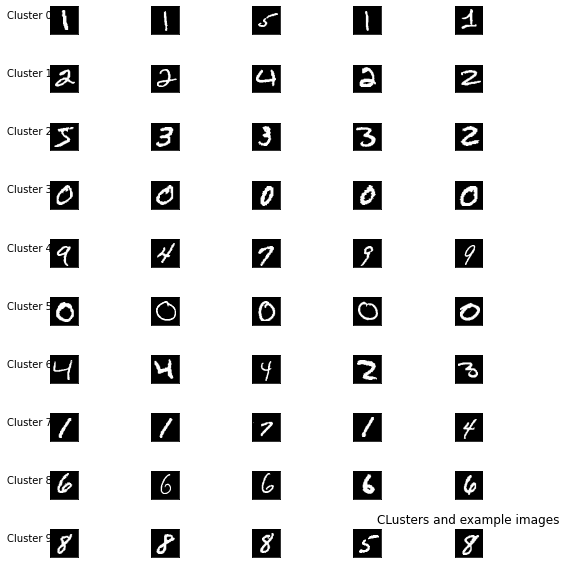

For cluster: 0 the most common label is: 1
For cluster: 1 the most common label is: 2
For cluster: 2 the most common label is: 3
For cluster: 3 the most common label is: 0
For cluster: 4 the most common label is: 7
For cluster: 5 the most common label is: 0
For cluster: 6 the most common label is: 9
For cluster: 7 the most common label is: 1
For cluster: 8 the most common label is: 6
For cluster: 9 the most common label is: 8


In [16]:
k_mean_plus_hyper_params = {'n_clusters': n_clusters, 'init': 'k-means++'}

silhouette_avg, completeness_avg, homogeneity_avg, acc, f1 = run_pipeline(np.array(x_train), y_train, KMeans, k_mean_plus_hyper_params, x_test, y_test)  

metrics_dict["kmeans++"] = dict(zip(["silhouette_avg", "completeness_avg", "homogeneity_avg", "acc", "f1"], [silhouette_avg, completeness_avg, homogeneity_avg, acc, f1]))


### AgglomerativeClustering

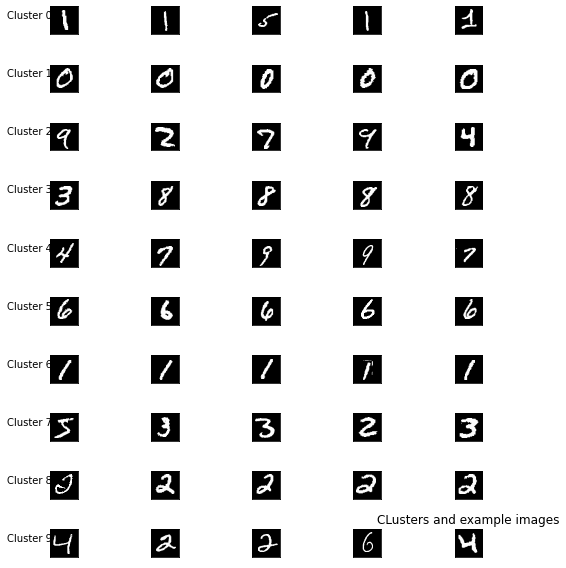

For cluster: 0 the most common label is: 1
For cluster: 1 the most common label is: 0
For cluster: 2 the most common label is: 9
For cluster: 3 the most common label is: 8
For cluster: 4 the most common label is: 4
For cluster: 5 the most common label is: 6
For cluster: 6 the most common label is: 1
For cluster: 7 the most common label is: 3
For cluster: 8 the most common label is: 2
For cluster: 9 the most common label is: 2


In [17]:
agg_hyper_params = {'n_clusters': 10}
silhouette_avg, completeness_avg, homogeneity_avg, acc, f1 = run_pipeline(np.array(x_train), y_train, AgglomerativeClusteringPredict, agg_hyper_params, x_test, y_test)  

metrics_dict["agglomerative"] = dict(zip(["silhouette_avg", "completeness_avg", "homogeneity_avg", "acc", "f1"], [silhouette_avg, completeness_avg, homogeneity_avg, acc, f1]))


#### GMM

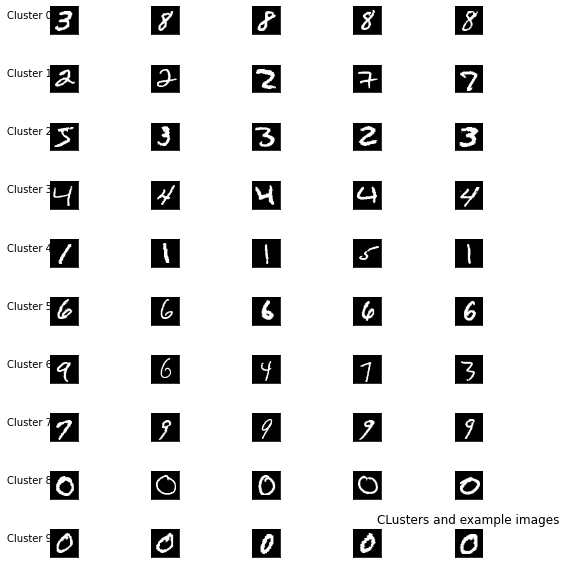

For cluster: 0 the most common label is: 2
For cluster: 1 the most common label is: 7
For cluster: 2 the most common label is: 3
For cluster: 3 the most common label is: 4
For cluster: 4 the most common label is: 1
For cluster: 5 the most common label is: 6
For cluster: 6 the most common label is: 9
For cluster: 7 the most common label is: 9
For cluster: 8 the most common label is: 0
For cluster: 9 the most common label is: 0


In [18]:
gmm_hyper_params = {'n_components': 10}
silhouette_avg, completeness_avg, homogeneity_avg, acc, f1 = run_pipeline(np.array(x_train), y_train, GaussianMixture, gmm_hyper_params, x_test, y_test)  

metrics_dict["gmm"] = dict(zip(["silhouette_avg", "completeness_avg", "homogeneity_avg", "acc", "f1"], [silhouette_avg, completeness_avg, homogeneity_avg, acc, f1]))


In [19]:
pd.DataFrame(metrics_dict)

,kmeans,kmeans++,agglomerative,gmm
silhouette_avg,0.090277,0.087400,0.065630,0.087452
completeness_avg,0.533965,0.538512,0.527554,0.539443
homogeneity_avg,0.523970,0.518632,0.504651,0.512306
acc,0.543314,0.546527,0.491527,0.430749
f1,0.514342,0.502407,0.439058,0.384171


### Dimensionality Reduction

In [35]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score



def visualize(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y.astype(int), cmap='viridis')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# define a function to train a logistic regression classifier and evaluate its performance
def train_classifier_and_evaluate(X_train, y_train, X_test, y_test):
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, f1

def reduce_dimensions(X_train, model, hyper_params_dict):
    model = model(**hyper_params_dict)
    new_X_train = model.fit_transform(X_train)
    return new_X_train

def main_dimenstionality_reduction(X_train, y_train, X_test, y_test, model, hyper_params_dict):
    new_X_train = reduce_dimensions(X_train, model, hyper_params_dict)
    visualize(new_X_train, y_train)
    accuracy, f1 = train_classifier_and_evaluate(X_train, y_train, X_test, y_test)
    return accuracy, f1



In [37]:
dimensionality_reduction_metrics_dict = {}

## PCA

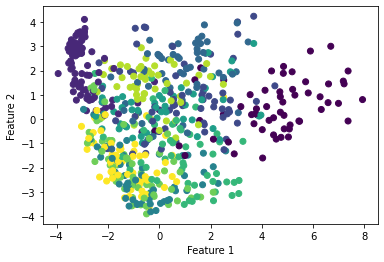

/Users/eyalmichaeli/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
hyper_params_dict = {
    "n_components": 50
    }
acc, f1 = main_dimenstionality_reduction(x_train, y_train, x_test, y_test, PCA, hyper_params_dict)
dimensionality_reduction_metrics_dict["pca"] = dict(zip(["acc", "f1"], [acc, f1]))


## TSNE

/Users/eyalmichaeli/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/eyalmichaeli/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


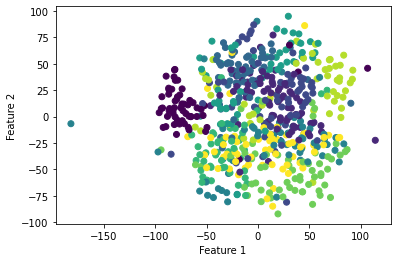

/Users/eyalmichaeli/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
from sklearn.manifold import TSNE

hyper_params_dict = {
    "n_components": 3,
    "method": 'barnes_hut'
    }
acc, f1 = main_dimenstionality_reduction(x_train, y_train, x_test, y_test, TSNE, hyper_params_dict)
dimensionality_reduction_metrics_dict["Tsne"] = dict(zip(["acc", "f1"], [acc, f1]))


## UMAP

In [ ]:
from sklearn.manifold import TSNE

hyper_params_dict = {
    "n_components": 3
    }
acc, f1 = main_dimenstionality_reduction(x_train, y_train, x_test, y_test, TSNE, hyper_params_dict)
dimensionality_reduction_metrics_dict["sne"] = dict(zip(["acc", "f1"], [acc, f1]))


In [ ]:
pd.DataFrame(dimensionality_reduction_metrics_dict).T

## Classification of the raw data